In [1]:
import random
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

# %env TF_KERAS=1
# import keras_self_attention

import jamo
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from unicode import join_jamos
from my_utils import get_datetimes

sns.set(style='whitegrid')

In [2]:
MODEL_NUMBER = 100

DIM = 200
TEST_SIZE = 0.1

DATA_DIR = 'lol'
DATA_TYPE = 'full-nouns-jamo-trigram'
DATA_TEXT_TYPE = 'title-contents'

EMBED_TYPE = 'wv'
DATA_EMBED_TYPE = '{}-{}{}'.format(DATA_TYPE, EMBED_TYPE, DIM)

if 'nouns' in DATA_TYPE:
    MAXLEN_TITLE = 16
    MAXLEN_LEDE = 24
    MAXLEN_CONTENTS = 128
else:
    MAXLEN_TITLE = 32
    MAXLEN_LEDE = 64
    MAXLEN_CONTENTS = 256

In [3]:
EMBEDDING_DIR = '4-embedding'
TRAINING_DATA_DIR = '5-training-data'
TRAINING_MODEL_DIR = '5-training-model'

embedding_dir = Path(EMBEDDING_DIR) / DATA_DIR
training_data_dir = Path(TRAINING_DATA_DIR) / DATA_DIR
training_model_dir = Path(TRAINING_MODEL_DIR) / DATA_DIR
training_checkpoint_dir = Path(training_model_dir) / 'classification-{}'.format(MODEL_NUMBER)

training_data_dir.mkdir(parents=True, exist_ok=True)
training_model_dir.mkdir(parents=True, exist_ok=True)
training_checkpoint_dir.mkdir(parents=True, exist_ok=True)

In [4]:
keras_model_path = training_model_dir / 'news-{}-{}-classification-{}'.format(DATA_EMBED_TYPE, DATA_TEXT_TYPE, MODEL_NUMBER)

### data

In [5]:
df = pd.read_csv(embedding_dir / 'news-{}.csv'.format(DATA_TYPE)).dropna()

_train_range = df.date.apply(lambda x: 20150000 < x < 20200000)
_test_range = df.date.apply(lambda x: 20200000 < x < 20210000)

def my_train_test_split(data):
    return data[_train_range], data[_test_range]

def my_train_val_test_split(data):
    train, test = my_train_test_split(data)
    train, val = train_test_split(train, test_size=0.1, random_state=119)
    return train, val, test

df_train, df_val, df_test = my_train_val_test_split(df)

In [6]:
# x_train_title, x_test_title = my_train_test_split(np.load(training_data_dir / 'news-{}-title.npy'.format(DATA_EMBED_TYPE)))
# x_train_contents, x_test_contents = my_train_test_split(np.load(training_data_dir / 'news-{}-contents.npy'.format(DATA_EMBED_TYPE)))
# # x_train_thumb, x_test_thumb = my_train_test_split(np.load(training_data_dir / 'news-thumbnail.npy'.format(DATA_TYPE))
# y_train, y_test = my_train_test_split(np.load(training_data_dir / 'news-view.npy'))
# y_train.shape, y_test.shape

x_train_title, x_val_title, x_test_title = my_train_val_test_split(np.load(training_data_dir / 'news-{}-title.npy'.format(DATA_EMBED_TYPE)))
x_train_contents, x_val_contents, x_test_contents = my_train_val_test_split(np.load(training_data_dir / 'news-{}-contents.npy'.format(DATA_EMBED_TYPE)))
# x_train_thumb, x_val_thumb, x_test_thumb = my_train_val_test_split(np.load(training_data_dir / 'news-thumbnail.npy'))
y_train, y_val, y_test = my_train_val_test_split(np.load(training_data_dir / 'news-view.npy'))
y_train.shape, y_val.shape, y_test.shape

((42417,), (4714,), (4155,))

In [7]:
range_train = np.logical_or(np.logical_and(y_train > 18000, (df_train.ranking <= 20).to_numpy()),
                            np.logical_and(y_train < 6000, (df_train.ranking > 30).to_numpy()))
range_val = np.logical_or(np.logical_and(y_val > 18000, (df_val.ranking <= 20).to_numpy()),
                           np.logical_and(y_val < 6000, (df_val.ranking > 30).to_numpy()))
range_test = np.logical_or(np.logical_and(y_test > 18000, (df_test.ranking <= 20).to_numpy()),
                           np.logical_and(y_test < 6000, (df_test.ranking > 30).to_numpy()))

print(sum(range_train), sum(df_train.ranking[range_train] <= 20), sum(df_train.ranking[range_train] > 20))
print(sum(range_val), sum(df_val.ranking[range_val] <= 20), sum(df_val.ranking[range_val] > 20))
print(sum(range_test), sum(df_test.ranking[range_test] <= 20), sum(df_test.ranking[range_test] > 20))

24914 12478 12436
2775 1356 1419
2681 1313 1368


In [8]:
N_CLASSES = 2

x_train_title = x_train_title[range_train]
x_val_title = x_val_title[range_val]
x_test_title = x_test_title[range_test]

x_train_contents = x_train_contents[range_train]
x_val_contents = x_val_contents[range_val]
x_test_contents = x_test_contents[range_test]

# x_train_thumb = x_train_thumb[range_train]
# x_test_thumb = x_test_thumb[range_test]

y_train = np.array(df_train.ranking[range_train] <= 20)
y_val = np.array(df_val.ranking[range_val] <= 20)
y_test = np.array(df_test.ranking[range_test] <= 20)

len(y_train), len(y_val), len(y_test)

(24914, 2775, 2681)

In [9]:
y_train = tf.keras.utils.to_categorical(y_train.astype('int32'))
y_val = tf.keras.utils.to_categorical(y_val.astype('int32'))
y_test = tf.keras.utils.to_categorical(y_test.astype('int32'))
y_train.shape, y_val.shape, y_test.shape

((24914, 2), (2775, 2), (2681, 2))

In [10]:
x_train = [x_train_title, x_train_contents]
x_val = [x_val_title, x_val_contents]
x_test = [x_test_title, x_test_contents]

In [13]:
dates = df.date_input.apply(lambda x: datetime.strptime(x, '%Y%m%d %H:%M'))

MAX_YEAR = 2020
MIN_YEAR = 2015
years = dates.apply(lambda x: x.year-MIN_YEAR / (MAX_YEAR-MIN_YEAR)).to_numpy().reshape((len(df), 1))

months = dates.apply(lambda x: x.month / 12).to_numpy().reshape((len(df), 1))
days = dates.apply(lambda x: x.day / 31).to_numpy().reshape((len(df), 1))
times = dates.apply(lambda x: (x.hour * 60 + x.second) / 1440).to_numpy().reshape((len(df), 1))

le = LabelEncoder()
offices = tf.keras.utils.to_categorical(le.fit_transform(df.office))

x_train_meta, x_val_meta, x_test_meta = my_train_val_test_split(np.concatenate([months, times], axis=1))
# x_train = [x_train_title, x_train_contents, x_train_meta]
# x_val = [x_val_title, x_val_contents, x_val_meta]
# x_test = [x_test_title, x_test_contents, x_test_meta]

(42417, 2)

### train

In [11]:
LSTM_UNITS_TITLE = 32
LSTM_UNITS_CONTENTS = 128
DROPOUT = 0.4

TRAIN_BATCH_SIZE = 4096
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
EPOCHS = 256

VERBOSE = 2

In [12]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        values, query = inputs
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [13]:
def build_text_model(input_shape, lstm_units, suffix):
    layer_lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, dropout=DROPOUT, name='lstm_{}'.format(suffix))
    layer_bilstm = tf.keras.layers.Bidirectional(layer_lstm, name='bilstm_{}'.format(suffix))
    layer_concat = tf.keras.layers.Concatenate(name='bilstm_hidden_state_{}'.format(suffix))
    layer_attention = BahdanauAttention(lstm_units, name='attention_{}'.format(suffix))
    # layer_attention = keras_self_attention.SeqWeightedAttention(return_attention=True, name='attention_{}'.format(suffix))
    
    inp = tf.keras.layers.Input(shape=input_shape, dtype='float32', name='input_{}'.format(suffix))
    bid, fwd_h, fwd_c, bwd_h, bwd_c = layer_bilstm(inp)
    bid_h = layer_concat([fwd_h, bwd_h])
    out, att_w = layer_attention([bid, bid_h])
    # out, att_w = layer_attention(bid)
    # att_w.set_shape((None, input_shape[0]))
    model = tf.keras.models.Model(inputs=inp, outputs=out, name='model_{}'.format(suffix))
    return model

def build_meta_model(input_shape, suffix):
    inp = tf.keras.layers.Input(shape=input_shape, dtype='float32', name='input_{}'.format(suffix))
    model = tf.keras.models.Model(inputs=inp, outputs=inp, name='model_{}'.format(suffix))
    return model

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_title (InputLayer)                         [(None, 16, 200)]                0                                                                   
______________________________________________________________________________________________________________________________________________________
input_contents (InputLayer)                      [(None, 128, 200)]               0                                                                   
______________________________________________________________________________________________________________________________________________________
bilstm_title (Bidirectional)                     [(None, 16, 64), (None, 32), (

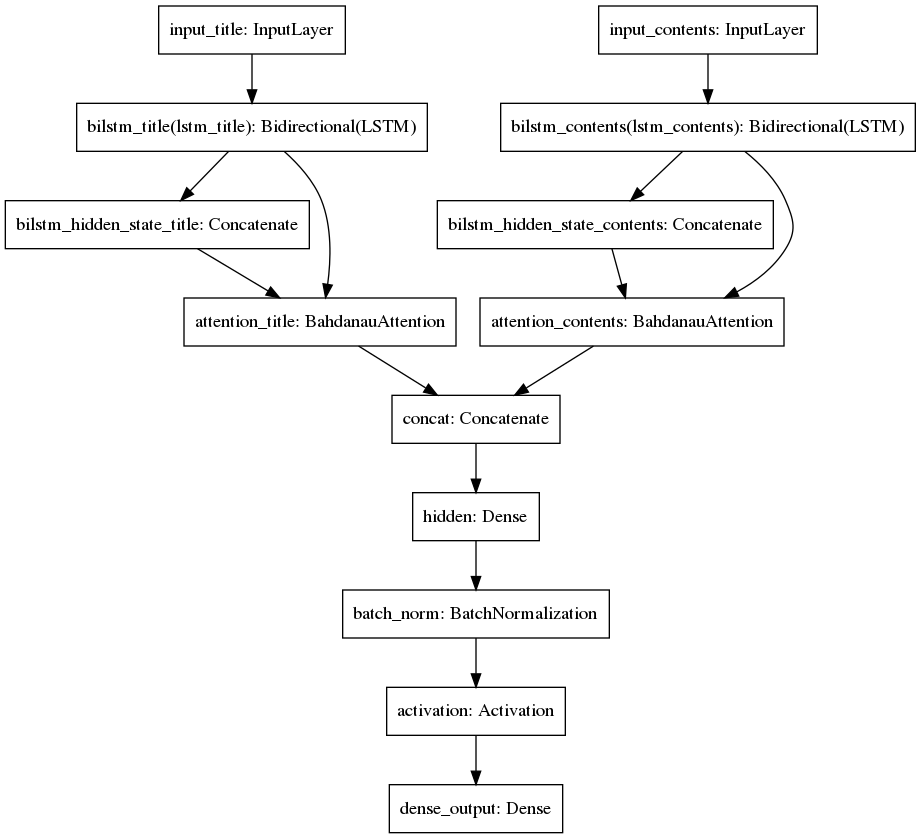

In [14]:
model_title = build_text_model(x_train_title.shape[1:], LSTM_UNITS_TITLE, suffix='title')
model_contents = build_text_model(x_train_contents.shape[1:], LSTM_UNITS_CONTENTS, suffix='contents')
# model_meta = build_meta_model(x_train_meta.shape[1:], suffix='meta')

x = tf.keras.layers.Concatenate(name='concat')([model_title.output, model_contents.output])
x = tf.keras.layers.Dense(x.shape[1], name='hidden')(x)
x = tf.keras.layers.BatchNormalization(name='batch_norm')(x)
x = tf.keras.layers.Activation(activation=tfa.activations.mish)(x)
out = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='dense_output')(x)

model = tf.keras.models.Model(inputs=[model_title.input, model_contents.input], outputs=out, name='model')
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary(line_length=150)
tf.keras.utils.plot_model(model)

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(training_checkpoint_dir / 'weights-{epoch:03d}-{val_loss:.4f}-{val_accuracy:.4f}.ckpt'),
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
)

In [16]:
hist = model.fit(
    x_train, y_train,
    batch_size=TRAIN_BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=VERBOSE,
    callbacks=[cp_callback]
)

Epoch 1/256
7/7 - 4s - loss: 0.9001 - accuracy: 0.6207 - val_loss: 0.6757 - val_accuracy: 0.5207
Epoch 2/256
7/7 - 3s - loss: 0.5305 - accuracy: 0.7325 - val_loss: 0.6674 - val_accuracy: 0.6007
Epoch 3/256
7/7 - 3s - loss: 0.5364 - accuracy: 0.7329 - val_loss: 0.6731 - val_accuracy: 0.5218
Epoch 4/256
7/7 - 3s - loss: 0.5142 - accuracy: 0.7462 - val_loss: 0.6612 - val_accuracy: 0.6184
Epoch 5/256
7/7 - 3s - loss: 0.5149 - accuracy: 0.7470 - val_loss: 0.6645 - val_accuracy: 0.6299
Epoch 6/256
7/7 - 3s - loss: 0.4819 - accuracy: 0.7640 - val_loss: 0.6797 - val_accuracy: 0.5002
Epoch 7/256
7/7 - 3s - loss: 0.5199 - accuracy: 0.7473 - val_loss: 0.6544 - val_accuracy: 0.7157
Epoch 8/256
7/7 - 3s - loss: 0.4713 - accuracy: 0.7728 - val_loss: 0.6660 - val_accuracy: 0.5467
Epoch 9/256
7/7 - 3s - loss: 0.4739 - accuracy: 0.7713 - val_loss: 0.6555 - val_accuracy: 0.6112
Epoch 10/256
7/7 - 3s - loss: 0.4671 - accuracy: 0.7771 - val_loss: 0.6588 - val_accuracy: 0.6173
Epoch 11/256
7/7 - 3s - loss:

In [17]:
model.save(keras_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 5-training-model/lol/news-full-nouns-jamo-trigram-wv200-title-contents-classification-100/assets


In [ ]:
tfa.register_all()
model = tf.keras.models.load_model(keras_model_path, custom_objects={'BahdanauAttention': BahdanauAttention})

### Scikit-learn

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
x_train_meta, x_val_meta, x_test_meta = my_train_val_test_split(np.concatenate([times], axis=1))
regr = RandomForestRegressor(random_state=119).fit(x_train_meta, y_train)

y_pred_rf_train = regr.predict(x_train_meta)
y_pred_rf_val = regr.predict(x_val_meta)
y_pred_rf = regr.predict(x_test_meta)

print('train')
print(int(metrics.mean_squared_error(y_train, y_pred_rf_train)))
print(int(metrics.mean_absolute_error(y_train, y_pred_rf_train)))
print(metrics.r2_score(y_train, y_pred_rf_train))
print()
print('val')
print(int(metrics.mean_squared_error(y_val, y_pred_rf_val)))
print(int(metrics.mean_absolute_error(y_val, y_pred_rf_val)))
print(metrics.r2_score(y_val, y_pred_rf_val))
print()
print('test')
print(int(metrics.mean_squared_error(y_test, y_pred_rf)))
print(int(metrics.mean_absolute_error(y_test, y_pred_rf)))
print(metrics.r2_score(y_test, y_pred_rf))

train
1130151000
20832
0.025093956629795966

val
1439436236
23579
-0.05780204382543763

test
694549413
17165
0.02111812994732787


(-1.0, 81.0)

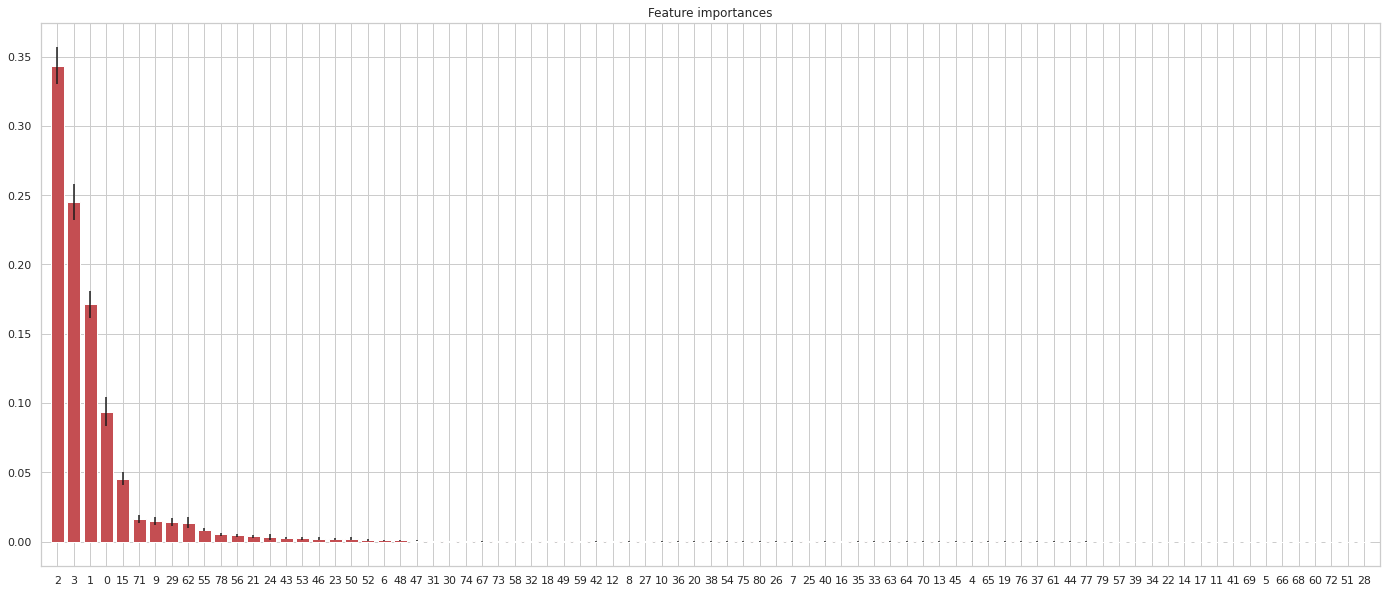

In [26]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.rcParams['figure.figsize'] = [24.0, 10.0]
plt.title('Feature importances')
plt.bar(range(x_train_meta.shape[1]), importances[indices],
        color="r", yerr=std[indices], align='center')
plt.xticks(range(x_train_meta.shape[1]), indices)
plt.xlim([-1, x_train_meta.shape[1]])

### attention

In [19]:
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic')

In [14]:
model.layers

In [15]:
layer_inp_title    = model.layers[0]
layer_att_title    = model.layers[4]
fn_title = K.function([layer_inp_title.input], [layer_att_title.output])

layer_inp_contents = model.layers[1]
layer_att_contents = model.layers[5]
fn_contents = K.function([layer_inp_contents.input], [layer_att_contents.output])

layer_dense_text  = model.layers[9]
fn_text = K.function([layer_inp_title.input, layer_inp_contents.input], [layer_dense_text.output])

In [94]:
N = -43
print('true:', y_train[N])
print('pred:', model.predict([x_train[0][N:N+1], x_train[1][N:N+1]], batch_size=1)[0][0])

true: 113091
pred: 22315.45


In [95]:
title_words = [join_jamos(x) for x in df_train.title.to_list()[N].split(' ')[:16]]
contents_words = [join_jamos(x) for x in df_train.contents.to_list()[N].split(' ')[:128]]
title = ' '.join(title_words)
contents = ' '.join(contents_words)
print(title)
print(contents)

현장 메모 분 조출 김정균_감독 페이커 이상혁 우승
텔레콤 프로_게임_단 김정균_감독 팀 핵심_멤버 페이커 이상혁 리프트_라이벌_즈 우승 확정 뒤 인터뷰 도착 관심


In [ ]:
att_w_vec = fn_title(x_train_title[N:N+1])[0][1][0]

att_w_vec_reverse = 1 / att_w_vec[:len(title_words)]
att_w_vec_reverse /= sum(att_w_vec_reverse)

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 160
plt.bar(title_words, att_w_vec_reverse)

In [ ]:
att_w_vec = fn_contents(x_test_contents[N:N+1])[0][1][0]
plt.rcParams['figure.figsize'] = [30.0, 10.0]
plt.bar(contents_words, att_w_vec[:len(contents_words)])

In [106]:
print('\n'.join(title_words))
print()
print('\n'.join(map(str, att_w_vec_reverse)))

현장
메모
분
조출
김정균_감독
페이커
이상혁
우승

0.0038936748
0.0019767403
7.31746e-05
0.0016659988
0.081711255
0.5141833
0.35645247
0.040043388


In [31]:
print('\n'.join(contents_words))
print()
print('\n'.join(map(str, att_w_vec[:len(contents_words)])))

한국
리프트_라이벌
결승전
중국
상대
리그
출범
후
우승
차지
대표
팀
일_서울_장충
체육관
리그_오브_레전드
리프트_라이벌
이하
리프트_라이벌_즈
결승전
인_빅_터스_게이밍
톱
스포츠
펀_플럭스_피닉스
게
밍
상대
대
승리
선봉장
킹_존
드래곤
조별_풀_리그
유일
승
텔레콤
인_빅_터스_게이밍
상대
초반
주도
데프_트
김혁규
활약
전투
승리
기분
출발
기세
텔레콤
톱
스포츠
상대
페이커
이상혁
니코
만
개
규모_전투
빛
유리
전투
구도
마타
조세
노틸러스
닻줄
적
발
승리
차지
세트
출전
그리핀
펀_플러스_피닉스
경기
김태상
판테온
기습
수차례
킬
허용
차례
전투
손해
만회
격차
게
밍
상대
세트
담원_게이밍
초반
베_이드
전략
선취점
킬
허용
협곡
전령
앞
규모_전투
베릴_조건희
알리스타
적
후방
완벽
역전
발판
전투
승리
기세
담원
사방
적
차례
승리
쐐기
대
승리
리프트_라이벌
출범
이후
처음
결승전
상대
승리
우승
차지

3.152039e-07
3.6165056e-07
1.0308206e-06
3.6083497e-06
1.7586094e-06
1.8560027e-06
1.3256463e-06
1.8441602e-06
1.2397836e-06
3.9481943e-06
5.106752e-06
1.3320594e-05
4.612721e-06
2.5790073e-06
1.8218827e-06
8.206639e-07
5.125074e-07
6.713155e-07
1.1668612e-06
1.2772858e-06
6.716281e-07
1.5256408e-06
1.3155909e-06
1.3088583e-06
7.4701205e-07
1.2413927e-06
6.2137957e-07
1.1236375e-06
8.772823e-07
1.056176e-06
2.274447e-06
8.5879924e-07
2.145507e-06
1.4968745e-06
1.6471963e-06
7.5204713e-07
1.3263392e-06
1.5765336e-06
7.571190

### evaluate

In [20]:
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true = np.argmax(y_test, axis=1)

In [25]:
# training_checkpoint_dir
model.load_weights(str(training_checkpoint_dir / 'weights-049-0.4725-0.7719.ckpt'))

In [26]:
y_score_train = model.predict(x_train, batch_size=TEST_BATCH_SIZE, verbose=0)
y_score_val = model.predict(x_val, batch_size=TEST_BATCH_SIZE, verbose=0)
y_score = model.predict(x_test, batch_size=TEST_BATCH_SIZE, verbose=0)

y_pred_train = np.argmax(y_score_train, axis=1)
y_pred_val = np.argmax(y_score_val, axis=1)
y_pred = np.argmax(y_score, axis=1)

In [27]:
print('train')
print(metrics.classification_report(y_true_train, y_pred_train))
print()
print('val')
print(metrics.classification_report(y_true_val, y_pred_val))
print()
print('test')
print(metrics.classification_report(y_true, y_pred, digits=4))

train
              precision    recall  f1-score   support

           0       0.80      0.85      0.82     12436
           1       0.84      0.78      0.81     12478

    accuracy                           0.82     24914
   macro avg       0.82      0.82      0.82     24914
weighted avg       0.82      0.82      0.82     24914


val
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1419
           1       0.78      0.75      0.76      1356

    accuracy                           0.77      2775
   macro avg       0.77      0.77      0.77      2775
weighted avg       0.77      0.77      0.77      2775


test
              precision    recall  f1-score   support

           0     0.7514    0.6959    0.7226      1368
           1     0.7058    0.7601    0.7319      1313

    accuracy                         0.7273      2681
   macro avg     0.7286    0.7280    0.7273      2681
weighted avg     0.7291    0.7273    0.7272      2681



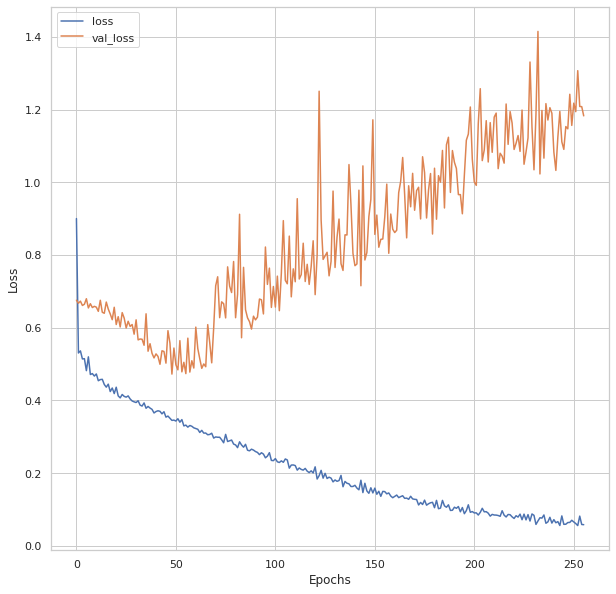

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

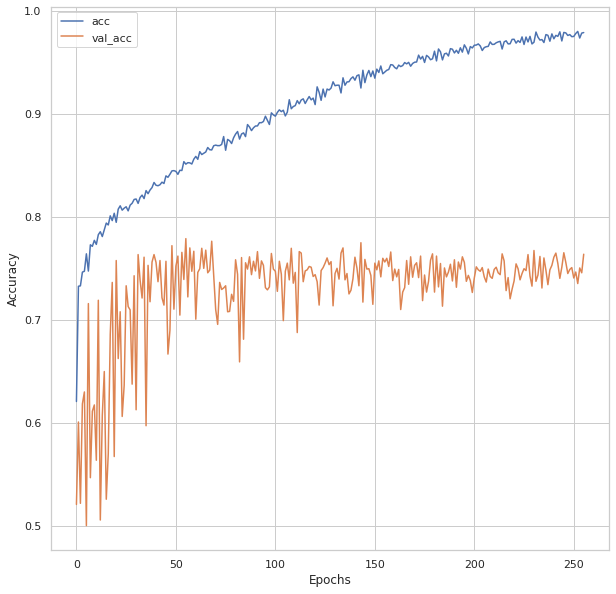

In [19]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [37]:
metrics.average_precision_score(y_true, np.asarray([y for x, y in y_score]))

0.8051558068718703

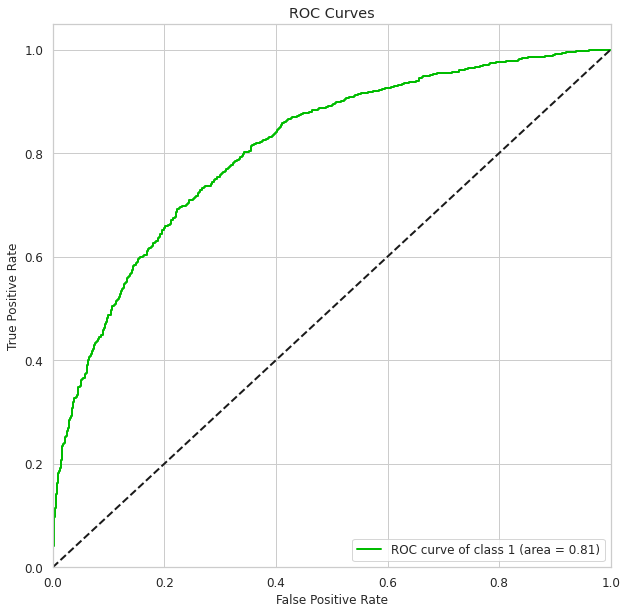

In [28]:
skplt.metrics.plot_roc(y_true, y_score, plot_micro=False, classes_to_plot=[1], plot_macro=False)

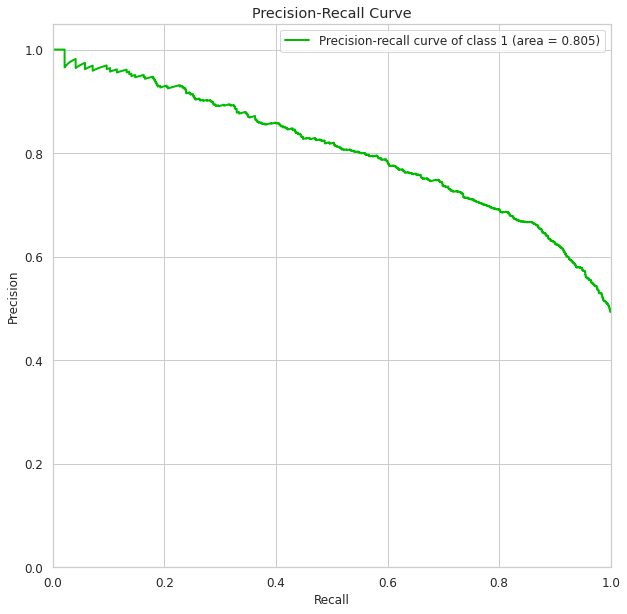

In [29]:
skplt.metrics.plot_precision_recall(y_true, y_score, classes_to_plot=[1], plot_micro=False)